In [57]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt

### Import package

In [8]:
import sys
import os
sys.path.append('../')
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("Data cleaning").getOrCreate()
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from yaml import load as yaml_load

### Import classes from src

In [5]:
from src.data.make_dataset import LoadDataframe
from src.features.build_features import extract_features_regression
from src.models.train_model import model_regression

### Functions to load yaml file configuration

In [9]:
def _load_config_file(config_file):
    """
    Load configuration file
    :param config_file: is the configuration file
    :return: configuration
    :rtype: dict
    """
    with open(config_file) as yml_config:
        return yaml_load(yml_config)

def _build_configuration(config_file):
    """
    Build the operation configuration dict
    :param config_file: is the path to the yaml config_file
    :type: string
    :return: config: global configuration
    :rtype dict
    """
    # yaml config
    config = _load_config_file(config_file)
    return config


In [28]:
def visualisation_prediction(y_test, y_pred):
    import matplotlib.pyplot as plt
    import matplotlib
    matplotlib.rc('xtick', labelsize=30) 
    matplotlib.rc('ytick', labelsize=30) 
    fig, ax = plt.subplots(figsize=(50, 40))
    plt.style.use('ggplot')
    plt.plot(y_pred, y_test, 'ro')
    plt.xlabel('Predicted Crime', fontsize = 30)
    plt.ylabel('Actual Crime', fontsize = 30)
    plt.title('Predicted Y (Crimes) to the Actual Y (Crimes)', fontsize = 30)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)

### Loads yaml file configuration

In [60]:
config_file = "/home/ml/Documents/Crime_Chigaco_Spark/config/config.yml"
config = _build_configuration(config_file)

In [67]:
config['model_ML_regression']['train_mode']

{'train': True,
 'start_date': 2012,
 'end_date': 2013,
 'predict_mode': {'predict': True, 'start_date': 2013, 'end_date': 2014},
 'param': {'maxIter': 100, 'maxDepth': 8},
 'path': {'path_model_regression': '../models/regression_Model',
  'path_results': '../reports/result_pred_regression.csv'}}

### Loads  LoadDataframe class, for more informations you can use help(LoadDataframe)

In [12]:
%%time
obj_df_loaded = LoadDataframe(config, '2012', '2013')

CPU times: user 286 µs, sys: 0 ns, total: 286 µs
Wall time: 289 µs


In [13]:
df_nb_crimes = obj_df_loaded.df_nb_crimes()

/usr/lib/spark/spark-2.4.0-bin-hadoop2.7/python/pyspark/sql/dataframe.py:1793: UserWarning: to_replace is a dict and value is not None. value will be ignored.
  warnings.warn("to_replace is a dict and value is not None. value will be ignored.")


In [15]:
df_nb_crimes.limit(5).toPandas().T

,0,1,2,3,4
community_area_number,10,11,13,16,17
month,10,10,12,2,10
year,2012,2012,2012,2012,2012
primary_type,DECEPTIVE PRACTICE,CRIMINAL DAMAGE,LIQUOR LAW VIOLATION,DECEPTIVE PRACTICE,NARCOTICS
nb_crimes,9,19,1,7,8
community_area_name,Norwood Park,Jefferson Park,North Park,Irving Park,Dunning
pct_housing_crowded,2,2.7,3.9,6.3,5.2
pct_households_below_poverty,5.4,8.6,13.2,13.1,10.6
pct_age16_unemployed,9,12.4,9.9,10,10
pct_age25_no_highschool,11.5,13.4,14.4,22.4,16.2


In [16]:
obj_extract_features_regression =  extract_features_regression(config, df_nb_crimes)

In [17]:
df_ml = obj_extract_features_regression.extract_feature()

In [18]:
obj_model_regression = model_regression(config, df_ml)

In [19]:
model = obj_model_regression.train_model()

### the model will be tested on 2014 data

In [20]:
%%time
obj_df_loaded_2014 = LoadDataframe(config, '2014', '2015')

CPU times: user 204 µs, sys: 30 µs, total: 234 µs
Wall time: 237 µs


### Loads data for testing

In [21]:
df_nb_crimes_2014 = obj_df_loaded.df_nb_crimes()

/usr/lib/spark/spark-2.4.0-bin-hadoop2.7/python/pyspark/sql/dataframe.py:1793: UserWarning: to_replace is a dict and value is not None. value will be ignored.
  warnings.warn("to_replace is a dict and value is not None. value will be ignored.")


### Extract features for 2014 data

In [22]:
obj_extract_features_regression_2014 =  extract_features_regression(config, df_nb_crimes_2014)
df_ml_2014 = obj_extract_features_regression_2014.extract_feature()

### Prediction

In [23]:
predictions = model.transform(df_ml_2014)

### Show some results

In [33]:
prediction_df = predictions.select('label','prediction').toPandas()

## Score 

In [27]:
predictions.printSchema()

root
 |-- label: long (nullable = false)
 |-- pct_housing_crowded: double (nullable = false)
 |-- pct_households_below_poverty: double (nullable = false)
 |-- pct_age16_unemployed: double (nullable = false)
 |-- pct_age25_no_highschool: double (nullable = false)
 |-- pct_not_working_age: double (nullable = false)
 |-- per_capita_income: double (nullable = false)
 |-- hardship_index: double (nullable = false)
 |-- primary_type_ARSON: long (nullable = true)
 |-- primary_type_CRIM SEXUAL ASSAULT: long (nullable = true)
 |-- primary_type_CRIMINAL DAMAGE: long (nullable = true)
 |-- primary_type_CRIMINAL TRESPASS: long (nullable = true)
 |-- primary_type_DECEPTIVE PRACTICE: long (nullable = true)
 |-- primary_type_GAMBLING: long (nullable = true)
 |-- primary_type_HOMICIDE: long (nullable = true)
 |-- primary_type_INTERFERENCE WITH PUBLIC OFFICER: long (nullable = true)
 |-- primary_type_INTIMIDATION: long (nullable = true)
 |-- primary_type_KIDNAPPING: long (nullable = true)
 |-- primary_t

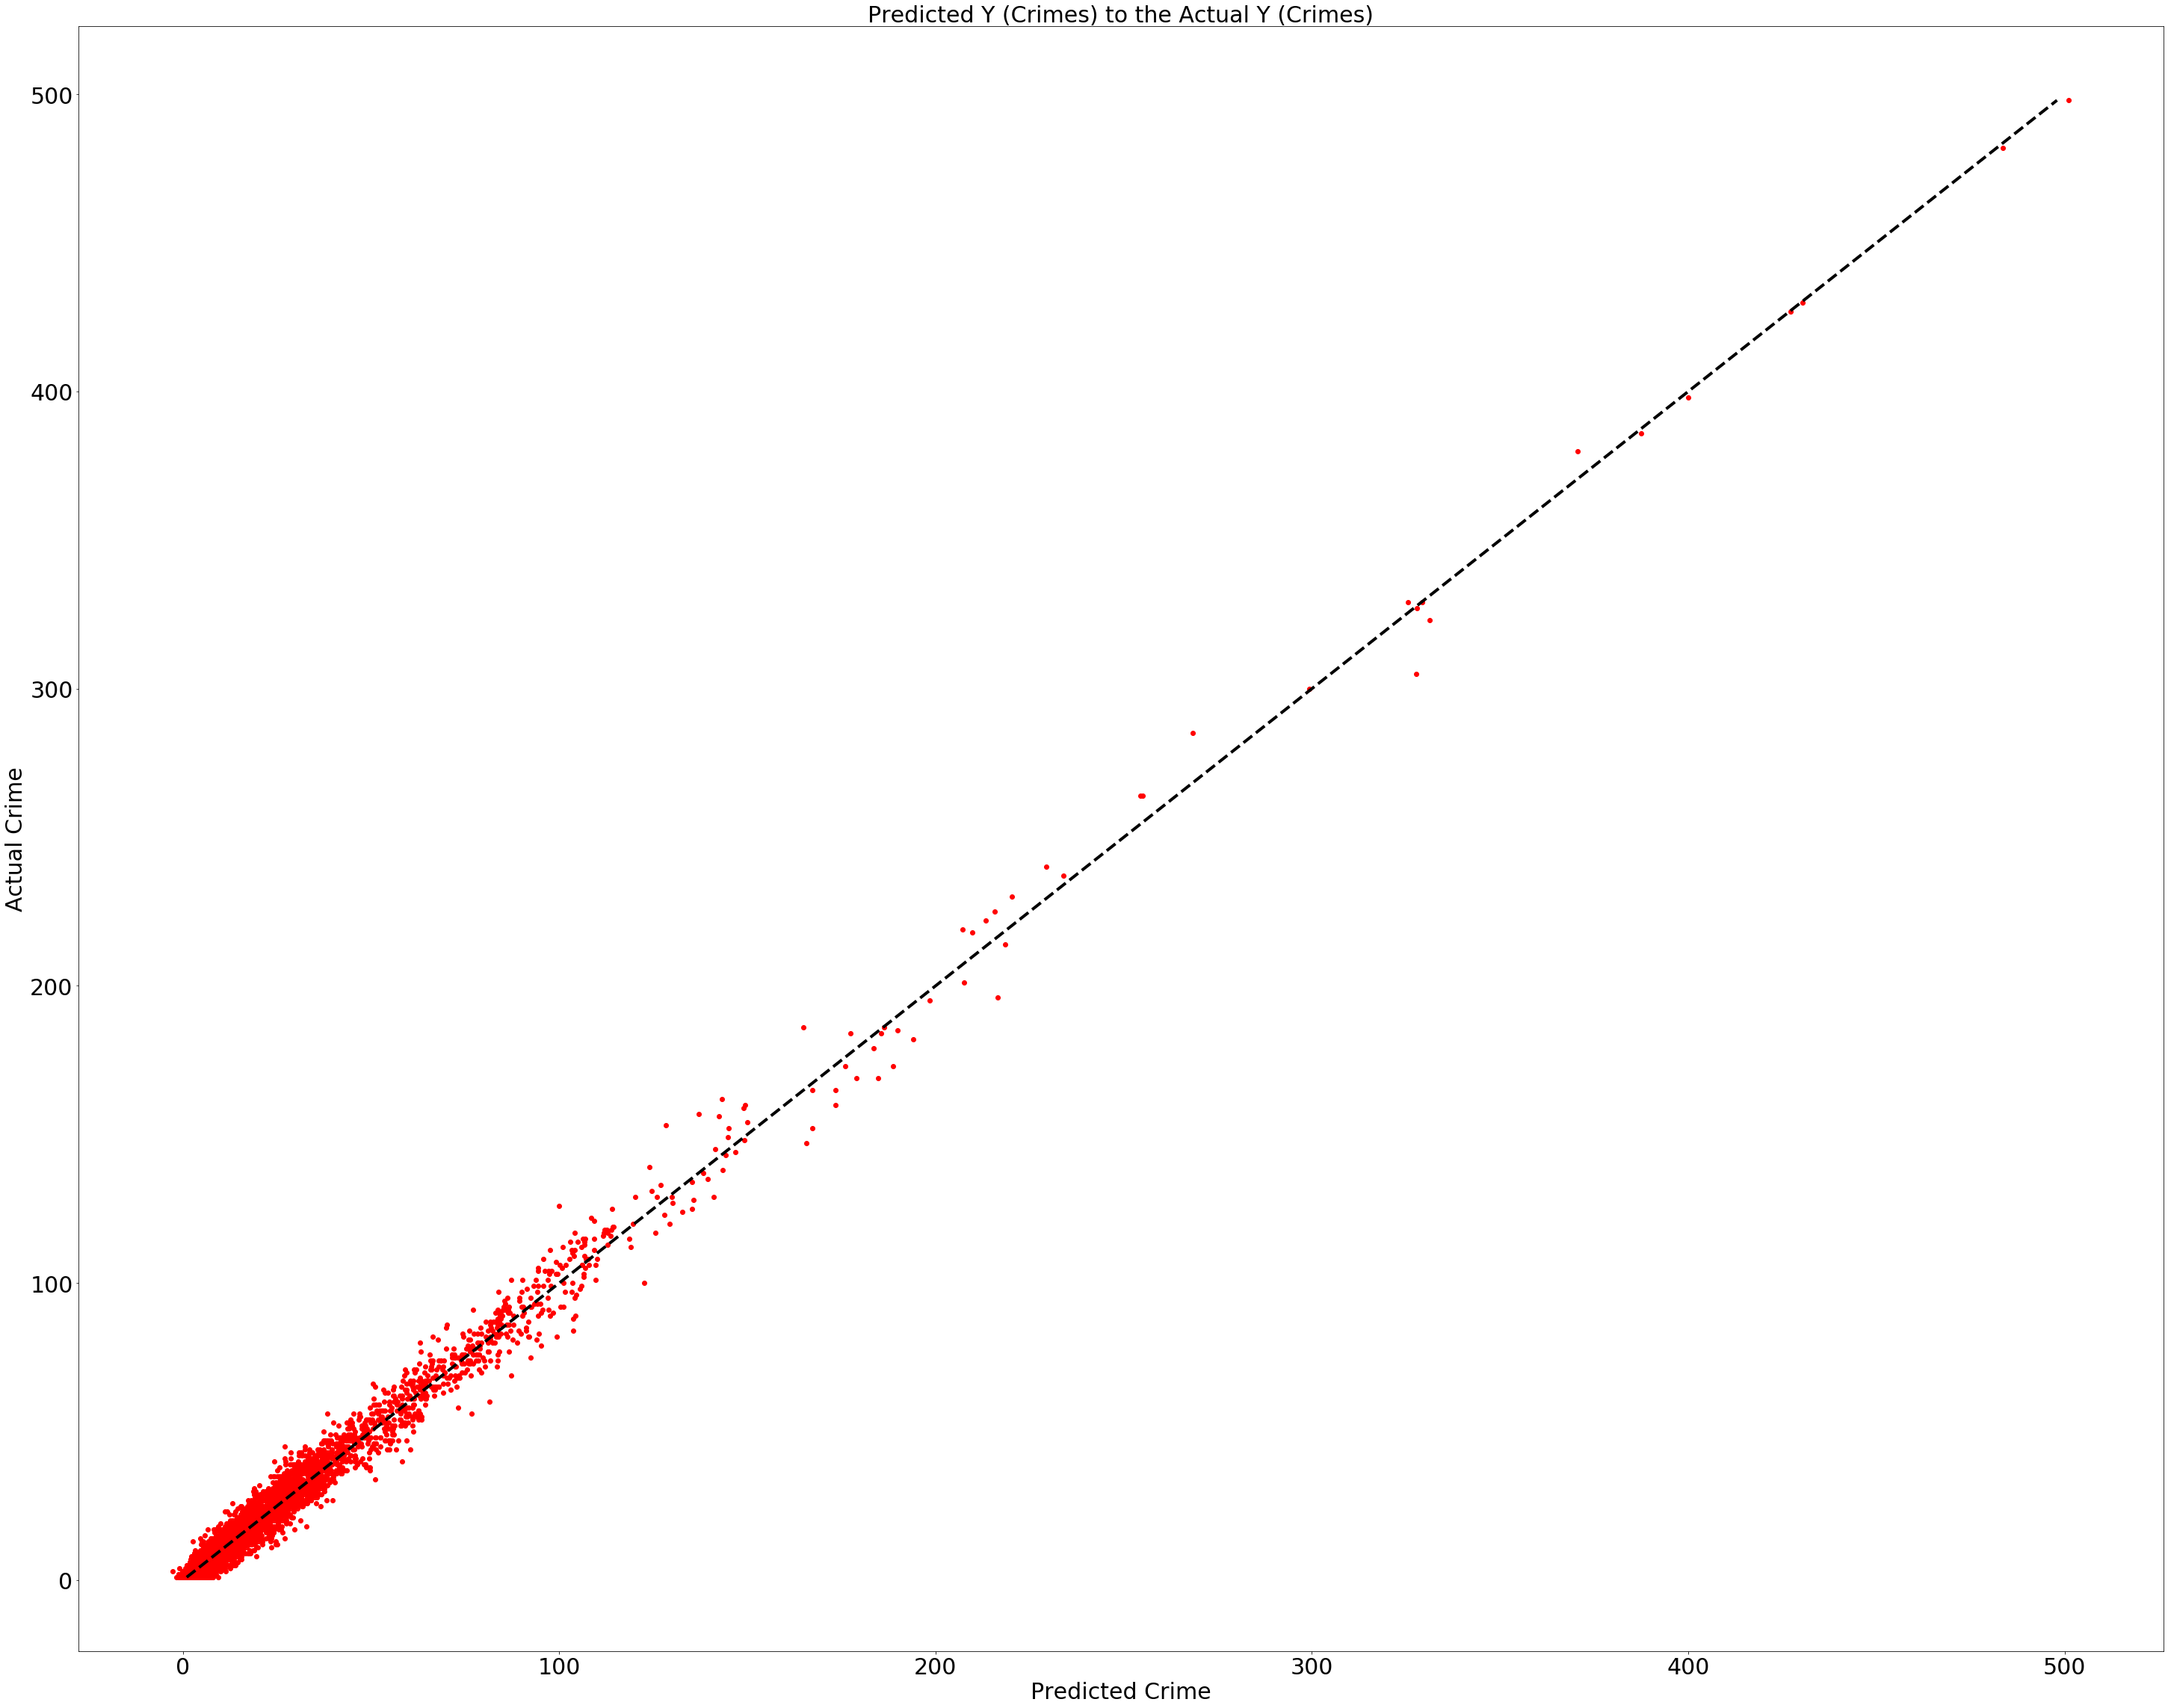

In [34]:
visualisation_prediction(prediction_df['label'], prediction_df['prediction'])